In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from sklearn.decomposition import PCA

In [2]:
from helper_funcs import *

In [3]:
data_latent_vec = np.load('../Data/latent_vecs3.npz')

In [4]:
list(data_latent_vec.keys())

['salient_vec_abide',
 'background_vec_abide',
 'vae_vec_abide',
 'salient_vec_sfari',
 'background_vec_sfari',
 'vae_vec_sfari']

In [5]:
salient_vec_abide = data_latent_vec['salient_vec_abide']
background_vec_abide = data_latent_vec['background_vec_abide']
vae_vec_abide = data_latent_vec['vae_vec_abide']
salient_vec_sfari = data_latent_vec['salient_vec_sfari']
background_vec_sfari = data_latent_vec['background_vec_sfari']
vae_vec_sfari = data_latent_vec['vae_vec_sfari']

In [6]:
def data2cmat(data):
    return np.array([squareform(pdist(data[s,:,:],metric='euclidean')) for s in range(data.shape[0])])

In [7]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False):
    #key = 'ADOS_gotham_PC1'
    import seaborn as sns
    from scipy.stats import ttest_1samp
    
    from scipy.stats import ttest_ind as ttest
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
        #sns.barplot(x=i,y=data.mean(axis=0)[i],errcolor='r',linewidth=2.5,facecolor=np.hstack((np.array(pallete_new[i]),.7)),edgecolor=np.hstack((np.array(pallete_new[i]),.7)))

    #xlbls = ['VAE','BG','SL']
    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['VAE','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)


    do_one_sample_stars = True
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['VAE','BG','SL']
        for i in range(c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['VAE','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    for comp_idx in range(len(comps)):
        this_comp = comps[comp_idx]
        sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
        max_y = new_y[-1] + comp_idx*.05
        xs = np.array(this_comp)
        stars = pairwise_sample_stars[sig_idx]
        plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
        plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    #plt.plot(plt.xlim(),[0,0],'k',linewidth=line_width)
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
        
    #plt.xlabel(key,fontsize=fontsize,labelpad=25.1,fontweight=fontweight)    
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [8]:
cmat_salient_vec_abide = data2cmat(salient_vec_abide)
cmat_background_vec_abide = data2cmat(background_vec_abide)
cmat_vae_vec_abide = data2cmat(vae_vec_abide)
cmat_salient_vec_sfari = data2cmat(salient_vec_sfari)
cmat_background_vec_sfari = data2cmat(background_vec_sfari)
cmat_vae_vec_sfari = data2cmat(vae_vec_sfari)

In [9]:
dataFnOut = '../Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '../Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [10]:
ABIDE_subs = np.load('../Data/ABIDE-subs-982.npz')['subs']
SFARI_subs = arr['subs']

In [11]:
assert len(df['BIDS_ID'].values)==len(ABIDE_subs), 'diff lengths'
assert all([df['BIDS_ID'].values[s]==ABIDE_subs[s] for s in range(len(ABIDE_subs))]), 'diff order'

In [12]:
corr = scipy.stats.stats.kendalltau
#corr = scipy.stats.stats.pearsonr
#patients = ~patients
corr_sl_bg = np.array([corr(get_triu(make_RDM(salient_vec_abide[i,patients,:])),get_triu(make_RDM(background_vec_abide[i,patients,:])))[0] for i in range(10)])
corr_vae_bg = np.array([corr(get_triu(make_RDM(vae_vec_abide[i,patients,:])),get_triu(make_RDM(background_vec_abide[i,patients,:])))[0] for i in range(10)])
corr_vae_sl = np.array([corr(get_triu(make_RDM(vae_vec_abide[i,patients,:])),get_triu(make_RDM(salient_vec_abide[i,patients,:])))[0] for i in range(10)])

In [13]:
# ALL SUBEJCTS
corr_sl_bg = np.array([corr(get_triu(make_RDM(salient_vec_abide[i,:,:])),get_triu(make_RDM(background_vec_abide[i,:,:])))[0] for i in range(10)])
corr_vae_bg = np.array([corr(get_triu(make_RDM(vae_vec_abide[i,:,:])),get_triu(make_RDM(background_vec_abide[i,:,:])))[0] for i in range(10)])
corr_vae_sl = np.array([corr(get_triu(make_RDM(vae_vec_abide[i,:,:])),get_triu(make_RDM(salient_vec_abide[i,:,:])))[0] for i in range(10)])

In [14]:
print(corr_sl_bg.mean().round(2))
print(corr_vae_bg.mean().round(2))
print(corr_vae_sl.mean().round(2))

0.09
0.12
0.04


In [15]:
df['random'] = np.random.rand(len(df))*10

## ABIDE

In [16]:
%time
# ABIDE MAKE MODELS 
plt.figure(figsize=(15,15))
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ','random']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio','ratio']

model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    #plt.subplot(4,4,i+1);
    inVec = df[default_keys[i]].values[patients];
    idx = ~np.isnan(inVec)
    inVec = inVec[idx];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    #sns.heatmap(this_rdm,cbar=[],xticklabels=[],yticklabels=[]);
    #plt.title(default_keys[i]);
    
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


<Figure size 1080x1080 with 0 Axes>

In [17]:
def slice_cmat(data,idx):
    mat = data[patients,:][:,patients]
    mat = mat[idx,:][:,idx]
    return mat

In [18]:
def fit_rsa(data,key):
    corr = scipy.stats.stats.pearsonr
    #corr = scipy.stats.stats.kendalltau
    r = np.array([corr(get_triu(slice_cmat(data[i,:,:],model_idxs[key])),get_triu(model_rdms[key]))[0] for i in range(10)])
    r = np.arctan(r)
    return r

In [19]:
# ABIDE FIT MODELS 
data = [cmat_vae_vec_abide,cmat_background_vec_abide,cmat_salient_vec_abide]
rsa_results = dict()
for key in default_keys:
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

In [20]:
# PCA RSA
keys_pca = {}
keys_pca.update({'ADOS_PCA' :  ['ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']})
keys_pca.update({'ADI_PCA' :   ['ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']})
keys_pca.update({'Vineland_PCA' :   ['VINELAND_Receptive_Vscore',
 'VINELAND_Expressive_Vscore',
 'VINELAND_Written_Vscore',
 'VINELAND_CommunicationStandard',
 'VINELAND_Personal_Vscore',
 'VINELAND_Domestic_Vscore',
 'VINELAND_Community_Vscore',
 'VINELAND_DaylyLiving_Standard',
 'VINELAND_Interpersonal_Vscore',
 'VINELAND_Play_Vscore',
 'VINELAND_Coping_Vscore',
 'VINELAND_Socical_Standard',
 'VINELAND_Domestic_Standard',
 'VINELAND_ABC_Standard',
 'VINELAND_Informant']})
keys_pca.update({'WISC_PCA' :  ['WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']})
# keys_pca.update({'' :   []})

In [21]:
# Calculate PCA RSA
pca_keys = list(keys_pca.keys())
for key in pca_keys:
    arr = np.array(df[keys_pca[key]])
    arr = arr[patients,:]

    idx = ~np.isnan(arr.mean(axis=1))
    mat = arr[idx,:]

    pca = PCA(n_components=1)
    rdm = make_RDM(pca.fit_transform(mat))
    model_rdms.update({key : rdm})
    model_idxs.update({key : idx})

    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

## SFARI

In [22]:
# data = SFARI_data
patients = sfari_subs_dupl+sfari_subs_del

In [23]:
%time
# SFARI
plt.figure(figsize=(15,15))
# default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
# scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']

default_keys = ['best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']
scales_ = [None,None,None,None,'ordinal','ordinal','ordinal','ordinal']

#model_rdms = dict()
#model_idxs = dict()
for i in range(8):
    #plt.subplot(4,4,i+1);
    inVec = dfs[default_keys[i]].values[patients];
    idx = ~np.isnan(inVec)
    inVec = inVec[idx];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    #sns.heatmap(this_rdm,cbar=[],xticklabels=[],yticklabels=[]);
    #plt.title(default_keys[i]);
    
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

CPU times: user 160 µs, sys: 165 µs, total: 325 µs
Wall time: 13.4 µs


<Figure size 1080x1080 with 0 Axes>

In [24]:
# SFARI FIT MODELS 
data = [cmat_vae_vec_sfari,cmat_background_vec_sfari,cmat_salient_vec_sfari]
#rsa_results = dict()
for key in default_keys:
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

In [25]:
keys = list(rsa_results.keys())
keys

['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'random',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',
 'best_full_scale_iq',
 'rrb_css',
 'sa_css',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

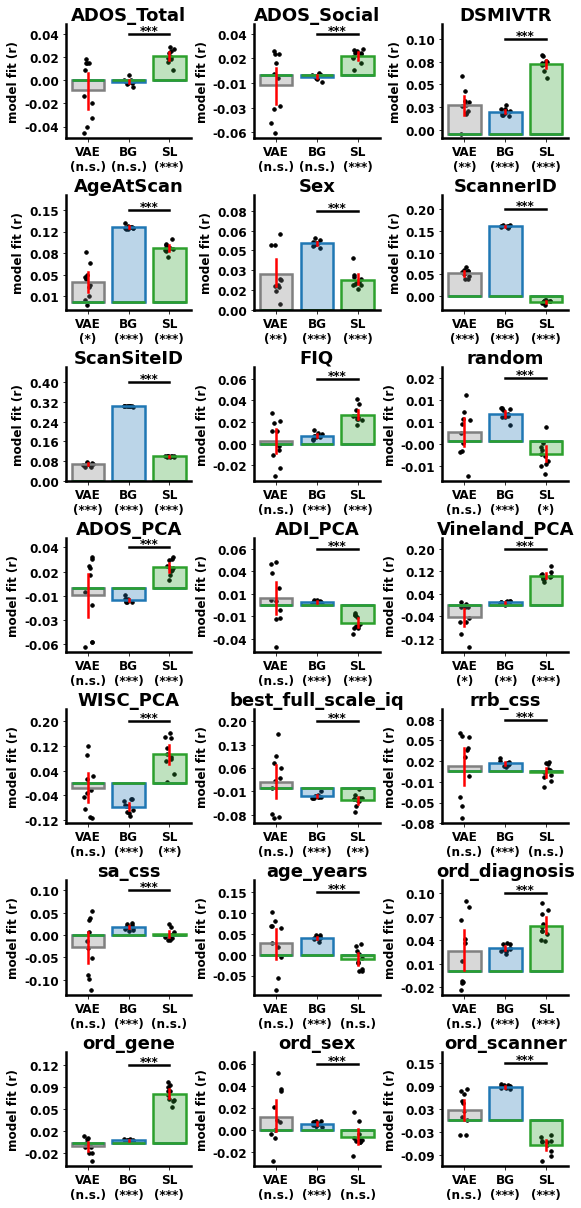

In [26]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))

plt.figure(figsize=np.array((ncols,nrows))*3)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_results,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12)
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

#plt.savefig('../figures/RSA_barplots_newData2.png')

In [27]:
## TTests 

keys = list(rsa_results.keys())

In [28]:
from scipy.stats import ttest_1samp

In [29]:
#key = keys[0]
for key in keys:

    data = rsa_results[key]
    dfs = data.shape[0]-1
    ttest_res = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
    space_lbls = ['VAE','BG','SL']
    for i in range(3):
        t,p = ttest_res[i,0],ttest_res[i,1]

        if p < .001:
            print(f'{key}-{space_lbls[i]} | $\\tau$ = {data[:,i].mean():.2f}, t({dfs}) = {t:.2f}, p $<$ .001')
        else:
            print(f'{key}-{space_lbls[i]} | $\\tau$ = {data[:,i].mean():.2f}, t({dfs}) = {t:.2f}, p = {p:.2f}')

ADOS_Total-VAE | $\tau$ = -0.01, t(9) = -1.00, p = 0.35
ADOS_Total-BG | $\tau$ = -0.00, t(9) = -1.26, p = 0.24
ADOS_Total-SL | $\tau$ = 0.02, t(9) = 11.52, p $<$ .001
ADOS_Social-VAE | $\tau$ = -0.01, t(9) = -1.00, p = 0.34
ADOS_Social-BG | $\tau$ = -0.00, t(9) = -2.18, p = 0.06
ADOS_Social-SL | $\tau$ = 0.02, t(9) = 9.32, p $<$ .001
DSMIVTR-VAE | $\tau$ = 0.03, t(9) = 5.90, p $<$ .001
DSMIVTR-BG | $\tau$ = 0.02, t(9) = 20.37, p $<$ .001
DSMIVTR-SL | $\tau$ = 0.07, t(9) = 32.46, p $<$ .001
AgeAtScan-VAE | $\tau$ = 0.03, t(9) = 3.96, p = 0.00
AgeAtScan-BG | $\tau$ = 0.12, t(9) = 133.21, p $<$ .001
AgeAtScan-SL | $\tau$ = 0.09, t(9) = 36.02, p $<$ .001
Sex-VAE | $\tau$ = 0.03, t(9) = 4.86, p $<$ .001
Sex-BG | $\tau$ = 0.05, t(9) = 72.02, p $<$ .001
Sex-SL | $\tau$ = 0.02, t(9) = 10.88, p $<$ .001
ScannerID-VAE | $\tau$ = 0.05, t(9) = 18.68, p $<$ .001
ScannerID-BG | $\tau$ = 0.16, t(9) = 305.67, p $<$ .001
ScannerID-SL | $\tau$ = -0.01, t(9) = -13.69, p $<$ .001
ScanSiteID-VAE | $\tau$ =

In [30]:
res = rsa_results['DSMIVTR']

DSMIVTR VAE >  VAE | t(9) = 0.00 p = 1.00
DSMIVTR VAE >  BG | t(9) = 1.26 p = 0.22
DSMIVTR VAE >  SL | t(9) = -7.95 p $<$ .001
DSMIVTR BG >  VAE | t(9) = -1.26 p = 0.22
DSMIVTR BG >  BG | t(9) = 0.00 p = 1.00
DSMIVTR BG >  SL | t(9) = -19.87 p $<$ .001
DSMIVTR SL >  VAE | t(9) = 7.95 p $<$ .001
DSMIVTR SL >  BG | t(9) = 19.87 p $<$ .001
DSMIVTR SL >  SL | t(9) = 0.00 p = 1.00


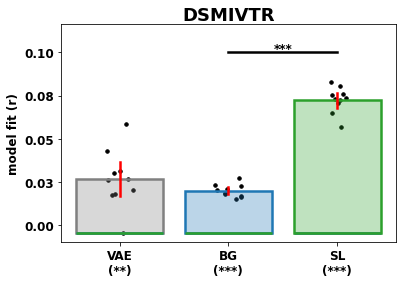

In [31]:
key = 'DSMIVTR'
plot_nice_bar(key,rsa_results,
              ax=ax,figsize=None,
              dpi=300,fontsize=12,
              fontsize_star=12,
              fontweight='bold',
              line_width=2.5,
              marker_size=12,report_t=True)

In [32]:
list(rsa_results.keys())

['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'random',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',
 'best_full_scale_iq',
 'rrb_css',
 'sa_css',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

In [33]:
#key = 'DSMIVTR'
#data = rsa_results[key]
    
def plot_rsa_bar(data,key,report_t=False):
    import scipy
    import seaborn as sns
    ttest_1samp = scipy.stats.ttest_1samp
    ttest_rel = scipy.stats.ttest_rel    
    
    # Calculate Plotting data
    c = data.shape[1]
    n = data.shape[0]
    xs = np.arange(c)
    xlbls = ['VAE','BG','SL']

    m = data.mean(axis=0)
    sd = data.std(axis=0)
    
    # T statistics
    t_1samp = np.array([ttest_1samp(data[:,i],0)[0] for i in range(c)])
    p_1samp = np.array([ttest_1samp(data[:,i],0)[1] for i in range(c)])

    p_paired_t = np.zeros((c,c))
    t_paired_t = np.zeros((c,c))

    # Bar, Errorbar, Scatter 
    for i in range(c):
        for j in range(c):
            t_paired_t[i,j] = ttest_rel(data[:,i],data[:,j])[0]
            p_paired_t[i,j] = ttest_rel(data[:,i],data[:,j])[1]
            

            
    print(f'{key},{data.mean(axis=0).round(2)}')
    if report_t:
        if p_paired_t[2,1] < .001:
            print(f'{key} {xlbls[2]} > {xlbls[1]}: t({data.shape[0]-1}) = {t_paired_t[2,1].round(2)}, p $<$ .001')
        else:
            print(f'{key} {xlbls[2]} > {xlbls[1]}: t({data.shape[0]-1}) = {t_paired_t[2,1].round(2)}, p = {p_paired_t[2,1].round(3)}')

        if p_paired_t[1,2] < .001:
            print(f'{key} {xlbls[1]} > {xlbls[2]}: t({data.shape[0]-1}) = {t_paired_t[1,2].round(2)}, p $<$ .001')
        else:
            print(f'{key} {xlbls[1]} > {xlbls[2]}: t({data.shape[0]-1}) = {t_paired_t[1,2].round(2)}, p = {p_paired_t[1,2].round(3)}')

    # Plotting
    fig, ax = plt.subplots(1,1)
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    linewidth = 3
    fontsize = 14
    fontweight='bold'
    for i in range(3):
        plt.bar(xs[i],m[i],edgecolor=np.hstack((pallete_new[i],1)),
                facecolor=np.hstack((pallete_new[i],.5)),
                linewidth=linewidth)

        plt.errorbar(xs[i],m[i],sd[i],fmt='r ',linewidth=linewidth)
        plt.scatter(x=(np.repeat(i,n)+(np.random.rand(n)-.5)*.25),y=data[:,i],
                   s=fontsize*3,
                   c='k')



    t_thresh = np.array((1,.05,.001,.0001));
    t_stars = np.array(('n.s.','*','**','***'));
    star_idx = (np.nonzero((p_paired_t[2,1] < t_thresh))[0]).max();
    plt.plot([1,2],np.repeat(data.max(),2)*1.25,'k',linewidth=linewidth);
    plt.text(1.4,data.max()*1.25+.002,t_stars[star_idx],fontsize=fontsize*1.25,fontweight='bold');

    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(linewidth);

    xlabels = ['VAE','BG','SL'];
    one_sample_star_idx = [(np.nonzero((p_1samp[ii] < t_thresh))[0]).max() for ii in range(c)];
    xlabels = [f'{xlabels[ii]}\n({t_stars[one_sample_star_idx[ii]]})' for ii in range(c)];

    #xticks = np.linspace(data.min().round(2),data.max().round(2),5)
    #plt.yticks(xticks,labels=[str(ii) for ii in xticks],fontsize=fontsize)
    plt.yticks(fontsize=fontsize,fontweight=fontweight);
    plt.xticks(xs,xlabels,fontsize=fontsize,fontweight=fontweight);
    plt.title(key,fontweight=fontweight,fontsize=fontsize*1.25,pad=fontsize)

In [34]:
keys = list(rsa_results.keys())
for key in keys:
    data = rsa_results[key]
    #plot_rsa_bar(data,key)
    print(f'{key} : {(data[:,1]-data[:,2]).mean().round(2)}')
#    print(data.mean(axis=0))

ADOS_Total : -0.02
ADOS_Social : -0.02
DSMIVTR : -0.05
AgeAtScan : 0.03
Sex : 0.03
ScannerID : 0.17
ScanSiteID : 0.2
FIQ : -0.02
random : 0.01
ADOS_PCA : -0.03
ADI_PCA : 0.02
Vineland_PCA : -0.1
WISC_PCA : -0.17
best_full_scale_iq : 0.01
rrb_css : 0.01
sa_css : 0.02
age_years : 0.05
ord_diagnosis : -0.03
ord_gene : -0.07
ord_sex : 0.01
ord_scanner : 0.15


In [35]:
keys = list(rsa_results.keys())

In [36]:
keys = ['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA']

In [37]:
diffs = np.array([rsa_results[key][:,2]-rsa_results[key][:,1] for key in keys])
nkeys = diffs.shape[0]
ord_ = np.argsort(diffs.mean(axis=1))
diffs_sorted = diffs[ord_,:]
keys_sorted = np.array(keys)[ord_]
p_vals = np.array([scipy.stats.ttest_rel(rsa_results[key][:,2],rsa_results[key][:,1])[1] < .05/12 for key in keys])
t_vals = np.array([scipy.stats.ttest_rel(rsa_results[key][:,2],rsa_results[key][:,1])[0] for key in keys])
p_vals_sorted = p_vals[ord_]
t_vals_sorted = t_vals[ord_]

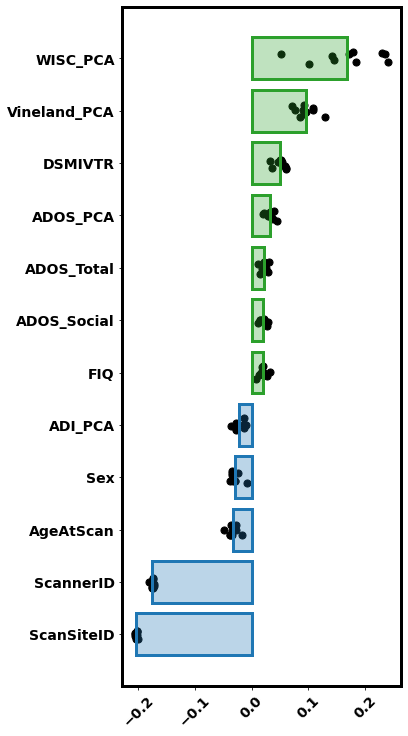

In [38]:
#fig,ax = plt.figure()
fig, ax = plt.subplots(1,1,figsize=np.array((2,5))*2.5)

pallete = sns.color_palette()
pallete_new = sns.color_palette()
pallete_new[1]=pallete[0];pallete_new[0]=pallete[1];pallete_new[0] = tuple(np.array((.5,.5,.5)))
bg_color = pallete_new[1]
sl_color = pallete_new[2]

linewidth = 3;fontsize = 14;fontweight='bold'
for idx,key in enumerate(keys):
    key = keys[idx]
    diff = diffs_sorted[idx,:]
    n = len(diff)
    m = diff.mean()
    sd = diff.std()
    
    if p_vals_sorted[idx] and (t_vals_sorted[idx]>0): # Significant Salient
        plt.barh(idx,m,facecolor=np.hstack((sl_color,.3)),edgecolor=np.hstack((sl_color,1)),linewidth=linewidth)
    elif p_vals_sorted[idx] and (t_vals_sorted[idx]<0): # Significant Background
        plt.barh(idx,m,facecolor=np.hstack((bg_color,.3)),edgecolor=np.hstack((bg_color,1)),linewidth=linewidth)
    else: # not significant
        plt.barh(idx,m,facecolor=[0,0,0,.1],edgecolor=[0,0,0,1],linewidth=linewidth)
        
    plt.scatter(x=diff,y=(np.repeat(idx,n)+(np.random.rand(n)-.5)*.25),c='k',s=50)
    
plt.yticks(np.arange(nkeys),labels=keys_sorted,fontsize=fontsize,fontweight=fontweight);
plt.xticks(fontsize=fontsize,fontweight=fontweight,rotation=45);
#plt.xlabel('model fit difference\nbackground      salient')

#ax.spines['top'].set_visible(False);
#ax.spines['right'].set_visible(False);
for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth);
        
plt.savefig('../figures/diverging bars/Diverging_bars_ABIDE.pdf')

In [39]:
keys = list(model_idxs.keys())

In [40]:
for key in keys:
    print(f'{key} | {model_idxs[key].sum()}'.rjust(25))

         ADOS_Total | 369
        ADOS_Social | 345
            DSMIVTR | 456
          AgeAtScan | 470
                Sex | 470
          ScannerID | 470
         ScanSiteID | 470
                FIQ | 428
             random | 470
           ADOS_PCA | 284
            ADI_PCA | 282
        Vineland_PCA | 69
            WISC_PCA | 22
  best_full_scale_iq | 50
             rrb_css | 51
              sa_css | 51
           age_years | 51
       ord_diagnosis | 51
            ord_gene | 51
             ord_sex | 51
         ord_scanner | 49


In [41]:
import umap
from tqdm import tqdm
from sklearn.decomposition import PCA
patients = df['DxGroup'].values==1
reducer = umap.UMAP()
reducer = PCA(n_components=2)

In [42]:
# # embedding = reducer.fit_transform(cmat_background_vec_abide[0,:,:][patients,:][:,patients])
# embedding = reducer.fit_transform(df['AgeAtScan'].values[patients].reshape(-1, 1) )
# plt.scatter(embedding[:,0],embedding[:,1])
# plt.title(key)

In [43]:
keys

['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'random',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',
 'best_full_scale_iq',
 'rrb_css',
 'sa_css',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

In [44]:
#reducer.fit_transform(bigData)

In [45]:
norm_arr = lambda sl_cmat : ((sl_cmat - sl_cmat.min()) / (sl_cmat.max()-sl_cmat.min()))

In [46]:
sl_cmat = cmat_salient_vec_abide[0,:,:][patients,:][:,patients]
bg_cmat = cmat_background_vec_abide[0,:,:][patients,:][:,patients]
vae_cmat = cmat_vae_vec_abide[0,:,:][patients,:][:,patients]

# sl_cmat = norm_arr(sl_cmat)
# bg_cmat = norm_arr(bg_cmat)
# vae_cmat = norm_arr(vae_cmat)

In [47]:
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    vec = inVec
    #vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())
    
    #vec = (vec - min(vec)) / (max(vec)-min(vec))
    #mat = (mat - min(mat)) / (max(mat)-min(mat))

    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

In [48]:
#vae_cmat[:,model_idxs[key]][model_idxs[key],:].max()


In [49]:
import scipy

In [50]:
keys

['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'random',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',
 'best_full_scale_iq',
 'rrb_css',
 'sa_css',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

In [52]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

best fit line:
y = 4.40 + 0.14x
best fit line:
y = 4.73 + 0.07x
best fit line:
y = 5.50 + 0.10x


Text(0.5, 1.08, 'DSMIVTR')

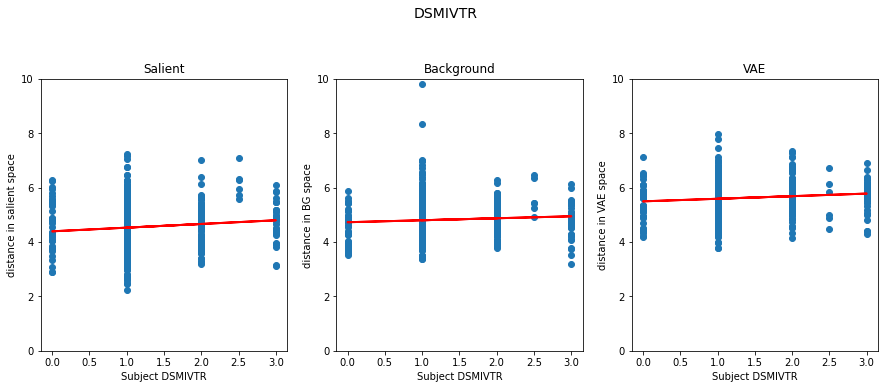

In [53]:
fig = plt.figure(figsize=(15,5))
#key = 'AgeAtScan'
key = 'ADOS_Total'
key = 'DSMIVTR'

v1 = df[key].values[patients][model_idxs[key]]
v_sl = scipy.linalg.norm(salient_vec_abide[0,:,:],axis=1)[patients][model_idxs[key]]
v_bg = scipy.linalg.norm(background_vec_abide[0,:,:],axis=1)[patients][model_idxs[key]]
v_vae = scipy.linalg.norm(vae_vec_abide[0,:,:],axis=1)[patients][model_idxs[key]]


plt.subplot(1,3,1)
plt.scatter(v1,v_sl)
plt.title('Salient')
plt.ylabel('distance in salient space')
plt.xlabel(f'Subject {key}')
#plt.xlim(0,triu_rdm.max());
plt.ylim(0,10)

a,b = best_fit(v1,v_sl)
yfit = [a + b * xi for xi in v1]
plt.plot(v1, yfit,'r',linewidth=2)


plt.subplot(1,3,2)
plt.scatter(v1,v_bg)
plt.title('Background')
plt.ylabel('distance in BG space')
plt.xlabel(f'Subject {key}')
#plt.xlim(0,triu_rdm.max());
plt.ylim(0,10)

a,b = best_fit(v1,v_bg)
yfit = [a + b * xi for xi in v1]
plt.plot(v1, yfit,'r',linewidth=2)

plt.subplot(1,3,3)
plt.scatter(v1,v_vae)
plt.title('VAE')
plt.ylabel('distance in VAE space')
plt.xlabel(f'Subject {key}')
#plt.xlim(0,triu_rdm.max())
plt.ylim(0,10)

a,b = best_fit(v1,v_vae)
yfit = [a + b * xi for xi in v1]
plt.plot(v1, yfit,'r',linewidth=2)


fig.suptitle(key, fontsize=14,y=1.08)

In [54]:
[np.corrcoef(v1,v)[0,1].round(3) for v in [v_sl,v_bg,v_vae]]

[0.114, 0.073, 0.104]

Text(0.5, 1.08, 'AgeAtScan')

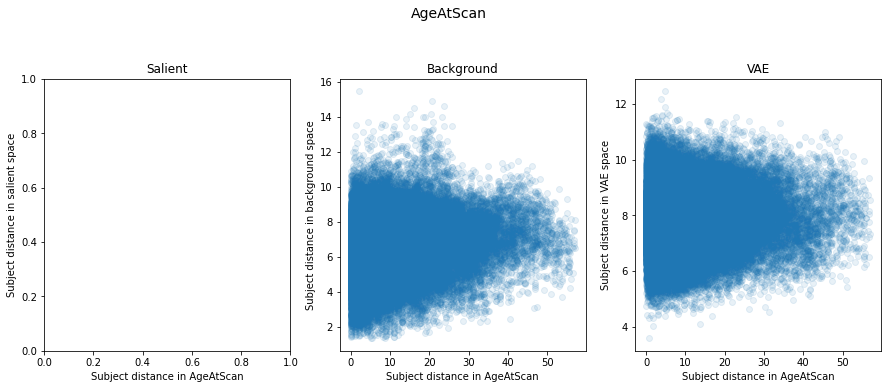

In [55]:
fig = plt.figure(figsize=(15,5))
key = 'AgeAtScan'
rdm = make_RDM(df[key].values[patients][model_idxs[key]])
#rdm = model_rdms[key]
triu_rdm = get_triu(rdm)
plt.subplot(1,3,1)
#plt.scatter(triu_rdm,get_triu(sl_cmat[:,model_idxs[key]][model_idxs[key],:]),alpha=.1)
plt.title('Salient')
plt.ylabel('Subject distance in salient space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)


plt.subplot(1,3,2)
plt.scatter(triu_rdm,get_triu(bg_cmat[:,model_idxs[key]][model_idxs[key],:]),alpha=.1)
plt.title('Background')
plt.ylabel('Subject distance in background space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

plt.subplot(1,3,3)
plt.scatter(triu_rdm,get_triu(vae_cmat[:,model_idxs[key]][model_idxs[key],:]),alpha=.1)
plt.title('VAE')
plt.ylabel('Subject distance in VAE space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

fig.suptitle(key, fontsize=14,y=1.08)

In [56]:
keys

['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'random',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',
 'best_full_scale_iq',
 'rrb_css',
 'sa_css',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

Text(0.5, 1.08, 'AgeAtScan')

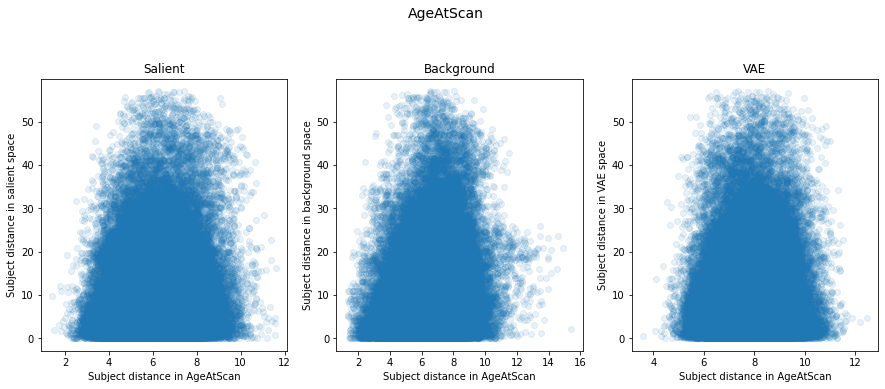

In [57]:
fig = plt.figure(figsize=(15,5))
key = 'AgeAtScan'
#key = 'ADOS_Total'
rdm = make_RDM(df[key].values[patients][model_idxs[key]])
#rdm = model_rdms[key]
triu_rdm = get_triu(rdm)
plt.subplot(1,3,1)
plt.scatter(get_triu(sl_cmat[:,model_idxs[key]][model_idxs[key],:]),triu_rdm,alpha=.1)
plt.title('Salient')
plt.ylabel('Subject distance in salient space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)


plt.subplot(1,3,2)
plt.scatter(get_triu(bg_cmat[:,model_idxs[key]][model_idxs[key],:]),triu_rdm,alpha=.1)
plt.title('Background')
plt.ylabel('Subject distance in background space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

plt.subplot(1,3,3)
plt.scatter(get_triu(vae_cmat[:,model_idxs[key]][model_idxs[key],:]),triu_rdm,alpha=.1)
plt.title('VAE')
plt.ylabel('Subject distance in VAE space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

fig.suptitle(key, fontsize=14,y=1.08)

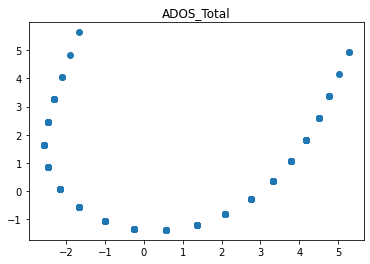

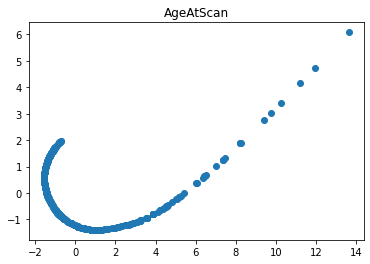

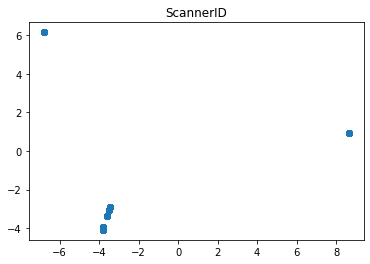

In [58]:
keys = list(model_rdms.keys())
for key in ['ADOS_Total','AgeAtScan','ScannerID']:
    plt.figure()
    bigData = model_rdms[key]
    #sns.heatmap(model_rdms[key])
    embedding = reducer.fit_transform(bigData)
    plt.scatter(embedding[:,0],embedding[:,1])
    plt.title(key)